In [3]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import Concatenate
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU
import numpy as np
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape,BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten, Conv2DTranspose
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift

In [4]:
# List physical GPUs and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('emnist-letters-train.csv', delimiter=',', header=None)

In [6]:
df = df[df[0] != -1]

In [7]:
# Define the mapping dictionary
mapping = {1: 0, 
           2: 1, 
           3: 2, 
           4: 3, 
           5: 4, 
           6: 5, 
           7: 6, 
           8: 7, 
           9: 8, 
           10: 9, 
           11: 10, 
           12: 11, 
           13: 12, 
           14: 13, 
           15: 14, 
           16: 15, 
           17: 16, 
           18: 17, 
           19: 18, 
           20: 19, 
           21: 20, 
           22: 21, 
           23: 22, 
           24: 23, 
           25: 24, 
           26: 25, 
           27: 26}

        # Map the labels column to its corresponding value
df[0] = df[0].map(mapping)

In [8]:
y_pre = np.array(df.iloc[:,0].values)
y_pre = pd.Categorical(y_pre)
X = np.array(df.iloc[:,1:].values)
X = X.reshape(-1,28,28,1)
preprocessed = []
for image in X:
    rotated_image = rotate(image, 90, reshape=False)
    flipped_image = np.flipud(rotated_image)
    preprocessed.append(flipped_image)
X_pre = np.array(preprocessed)
X = X_pre
X = X.astype('float32')
X_pre = (X - 127.5) / 127.5

In [9]:
y_pre
unique_values = len(np.unique(y_pre))
value_counts = np.unique(y_pre, return_counts=True)
for value, count in zip(value_counts[0], value_counts[1]):
    print(f"Value {value}: {count} occurrences")
print(unique_values)

Value 0: 3396 occurrences
Value 1: 3396 occurrences
Value 2: 3419 occurrences
Value 3: 3398 occurrences
Value 4: 3437 occurrences
Value 5: 3394 occurrences
Value 6: 3385 occurrences
Value 7: 3424 occurrences
Value 8: 3428 occurrences
Value 9: 3402 occurrences
Value 10: 3438 occurrences
Value 11: 3415 occurrences
Value 12: 3402 occurrences
Value 13: 3365 occurrences
Value 14: 3408 occurrences
Value 15: 3430 occurrences
Value 16: 3435 occurrences
Value 17: 3419 occurrences
Value 18: 3392 occurrences
Value 19: 3436 occurrences
Value 20: 3419 occurrences
Value 21: 3422 occurrences
Value 22: 3423 occurrences
Value 23: 3437 occurrences
Value 24: 3453 occurrences
Value 25: 3427 occurrences
26


In [10]:
max_count = df[0].value_counts().max()

# Function to augment images
def augment_image(image):
    # Rotation
    angle = random.uniform(-15, 15)  # Rotate between -15 to 15 degrees
    rotated_image = rotate(image, angle, reshape=False)
    # Shifting
    shift_val = random.uniform(-2, 2)  # Shift between -2 to 2 pixels
    shifted_image = shift(rotated_image, shift=(shift_val, shift_val, 0), mode='nearest')
    return shifted_image

# Augment the dataset to balance the number of samples per label
balanced_X = []
balanced_y = []

for label in np.unique(y_pre):
    label_indices = np.where(y_pre == label)[0]
    label_images = X_pre[label_indices]
    
    # Check if there are no images for the current label
    if len(label_images) == 0:
        continue
    
    # If the number of samples is less than max_count, augment the images
    if len(label_images) < max_count:
        augmented_images = []
        for i in range(max_count - len(label_images)):
            img = label_images[i % len(label_images)]
            augmented_images.append(augment_image(img))
        label_images = np.concatenate((label_images, augmented_images), axis=0)
    
    balanced_X.extend(label_images)
    balanced_y.extend([label] * max_count)

# Convert to numpy arrays
balanced_X = np.array(balanced_X)
balanced_y = np.array(balanced_y)

print(f"Original dataset shape: {X_pre.shape}")
print(f"Balanced dataset shape: {balanced_X.shape}")
print(f"Labels distribution: {np.unique(balanced_y, return_counts=True)}")

Original dataset shape: (88800, 28, 28, 1)
Balanced dataset shape: (89778, 28, 28, 1)
Labels distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64), array([3453, 3453, 3453, 3453, 3453, 3453, 3453, 3453, 3453, 3453, 3453,
       3453, 3453, 3453, 3453, 3453, 3453, 3453, 3453, 3453, 3453, 3453,
       3453, 3453, 3453, 3453], dtype=int64))


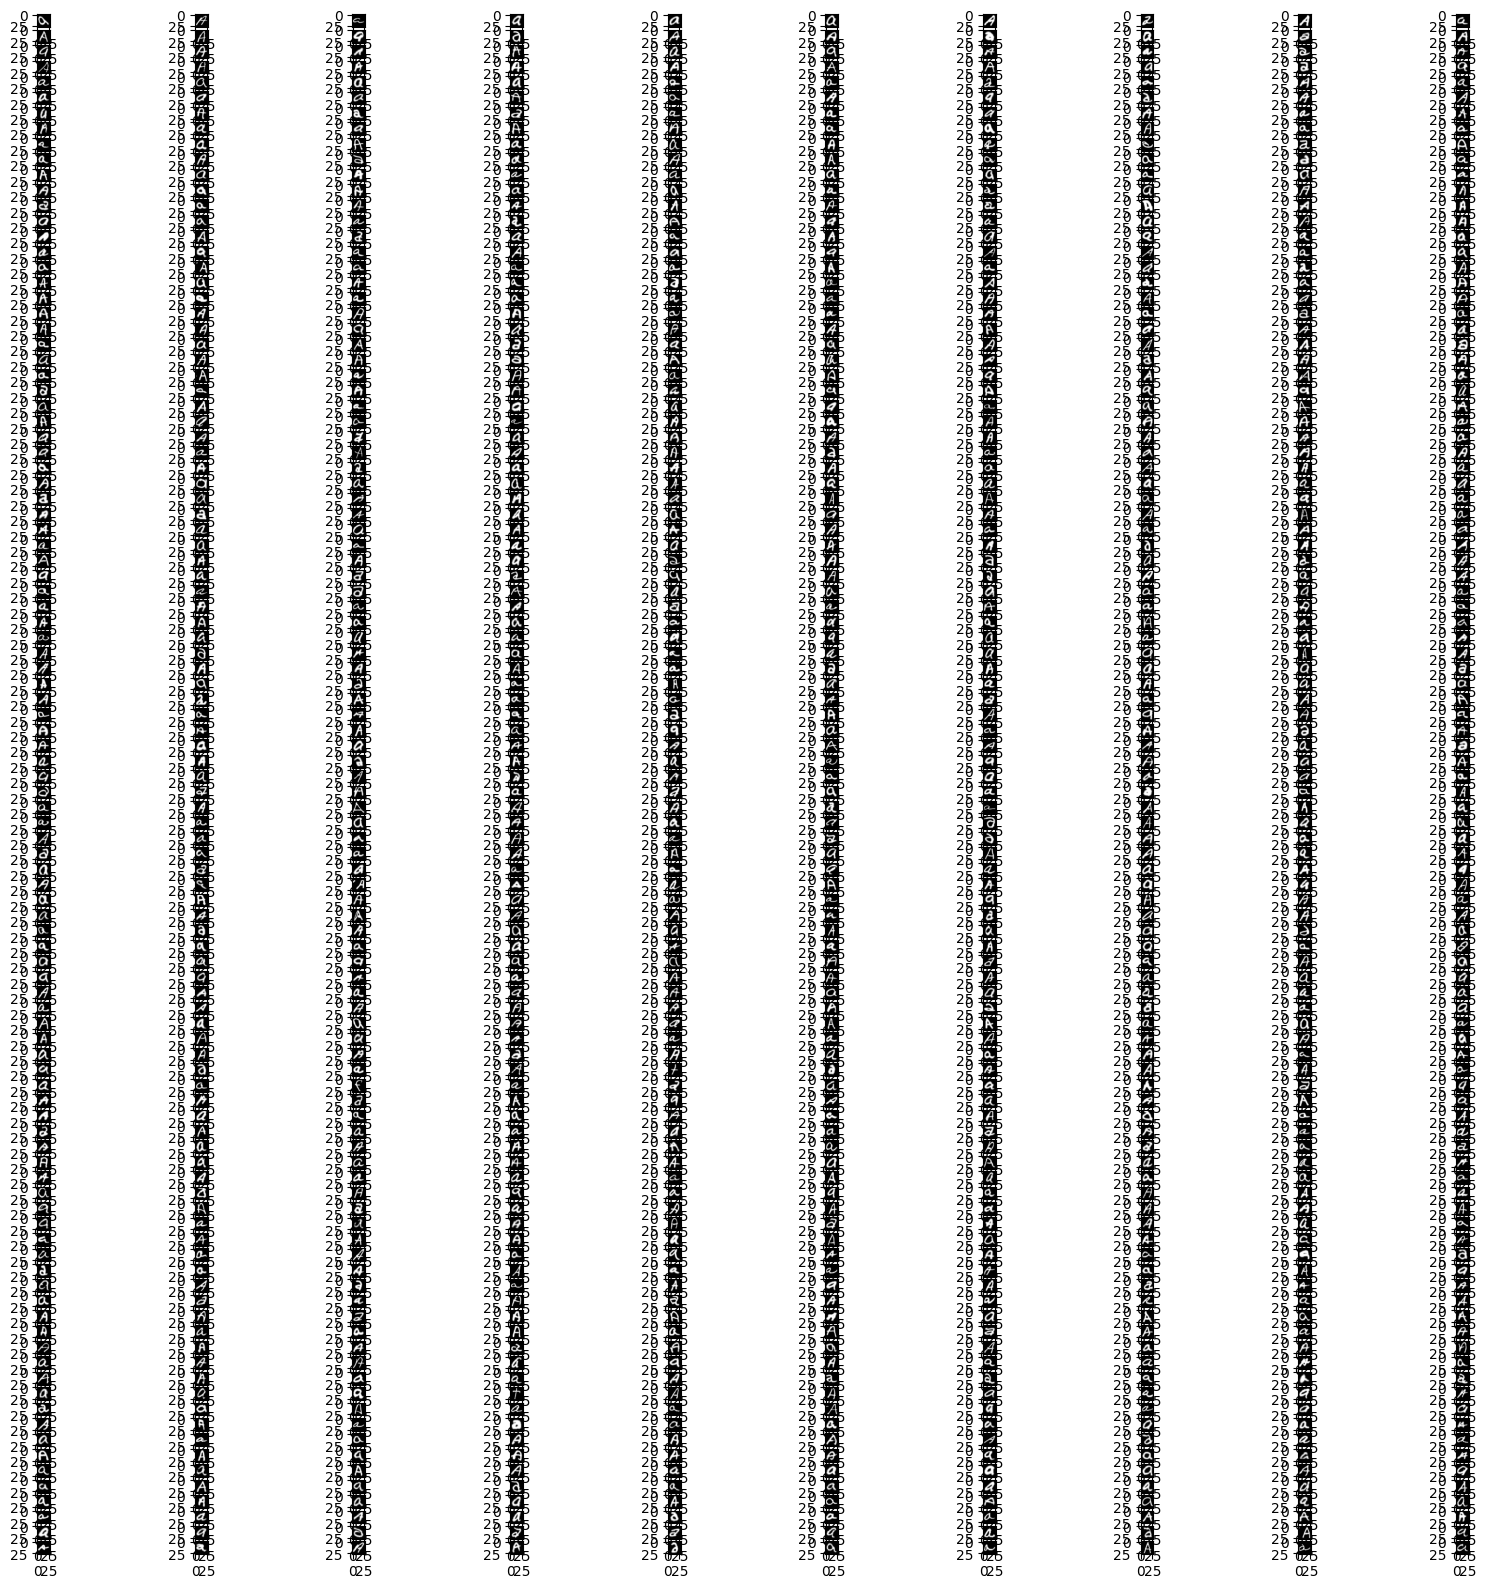

In [14]:
plt.figure(figsize=(20, 20))

for i in range(1000):
    plt.subplot(100, 10, 1 + i)
    plt.imshow(balanced_X[i], cmap='gray')
plt.show()

In [9]:
class DCGAN():
    def __init__(self, rows, cols, channels, z=100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        optimizer = Adam(0.0002, 0.5, 0.99)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(512 * 7 * 7, activation="relu", input_dim=self.latent_dim))  # connect the input to dense layer
        model.add(Reshape((7, 7, 512)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same", activation='tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(1024, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        fig.suptitle(f'Epoch : {epoch} G:512,256,128 | D:128,256,512,1024 |\n| lr:0.002 ', fontsize=12)
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        os.makedirs('AUG DCGAN', exist_ok=True)
        fig.savefig("AUG DCGAN/DCGAN_{:d}.png".format(epoch))
        plt.close()

    def train(self, epochs, batch_size=1024, save_interval=1):
        # Load the dataset
        X_train = balanced_X
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        batches_per_epoch = X_train.shape[0] // batch_size
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):

                # ---------------------
                # Train Discriminator
                # ---------------------
                # Select a random half of images
                for _ in range(2):
                    idx = np.random.randint(0, X_train.shape[0], batch_size)
                    imgs = X_train[idx]
                    # Sample noise and generate a batch of new images
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    gen_imgs = self.generator.predict(noise)
                    # Train the discriminator (real classified as ones
                    # and generated as zeros)
                    self.discriminator.trainable = True
                    d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                    # ---------------------
                    # Train Generator
                    # ---------------------
                    self.discriminator.trainable = False
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print("Epoch: %d/%d  Batch Size: %d/%d [loss: %f, acc.: %.2f%%] [G loss: %f]" % (
                epoch, epochs, batch, batches_per_epoch, d_loss[0], 100 * d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)


In [10]:
dcgan_Improved = DCGAN(28,28,1)
dcgan_Improved.train(epochs=200, batch_size=1024, save_interval=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 256)        1024      
 hNormalization)                                        